In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')

# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2

# predefined figsize
figsize=(20,10)

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("../dataset/original/train.csv")
test = pd.read_csv("../dataset/original/x_test.csv")

def convert_date(df):
    df["Unnamed: 0"] = df["Unnamed: 0"].str.split(" ")
    df["Unnamed: 0"] = df["Unnamed: 0"].apply(lambda x: "-".join(x[1:]))
    df = df.rename(columns = {'Unnamed: 0':'Date'})
    df.Date = pd.to_datetime(df.Date)
    return df    

df = pd.concat([train, test])
df = convert_date(df)

train = convert_date(train)
test = convert_date(test)

df = df.sort_values(['sku','Date'])
df = df.reset_index(drop=True)

# Encoding Categorical Features

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.pack = le.fit_transform(df.pack)
df.brand = le.fit_transform(df.brand)

In [3]:
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)

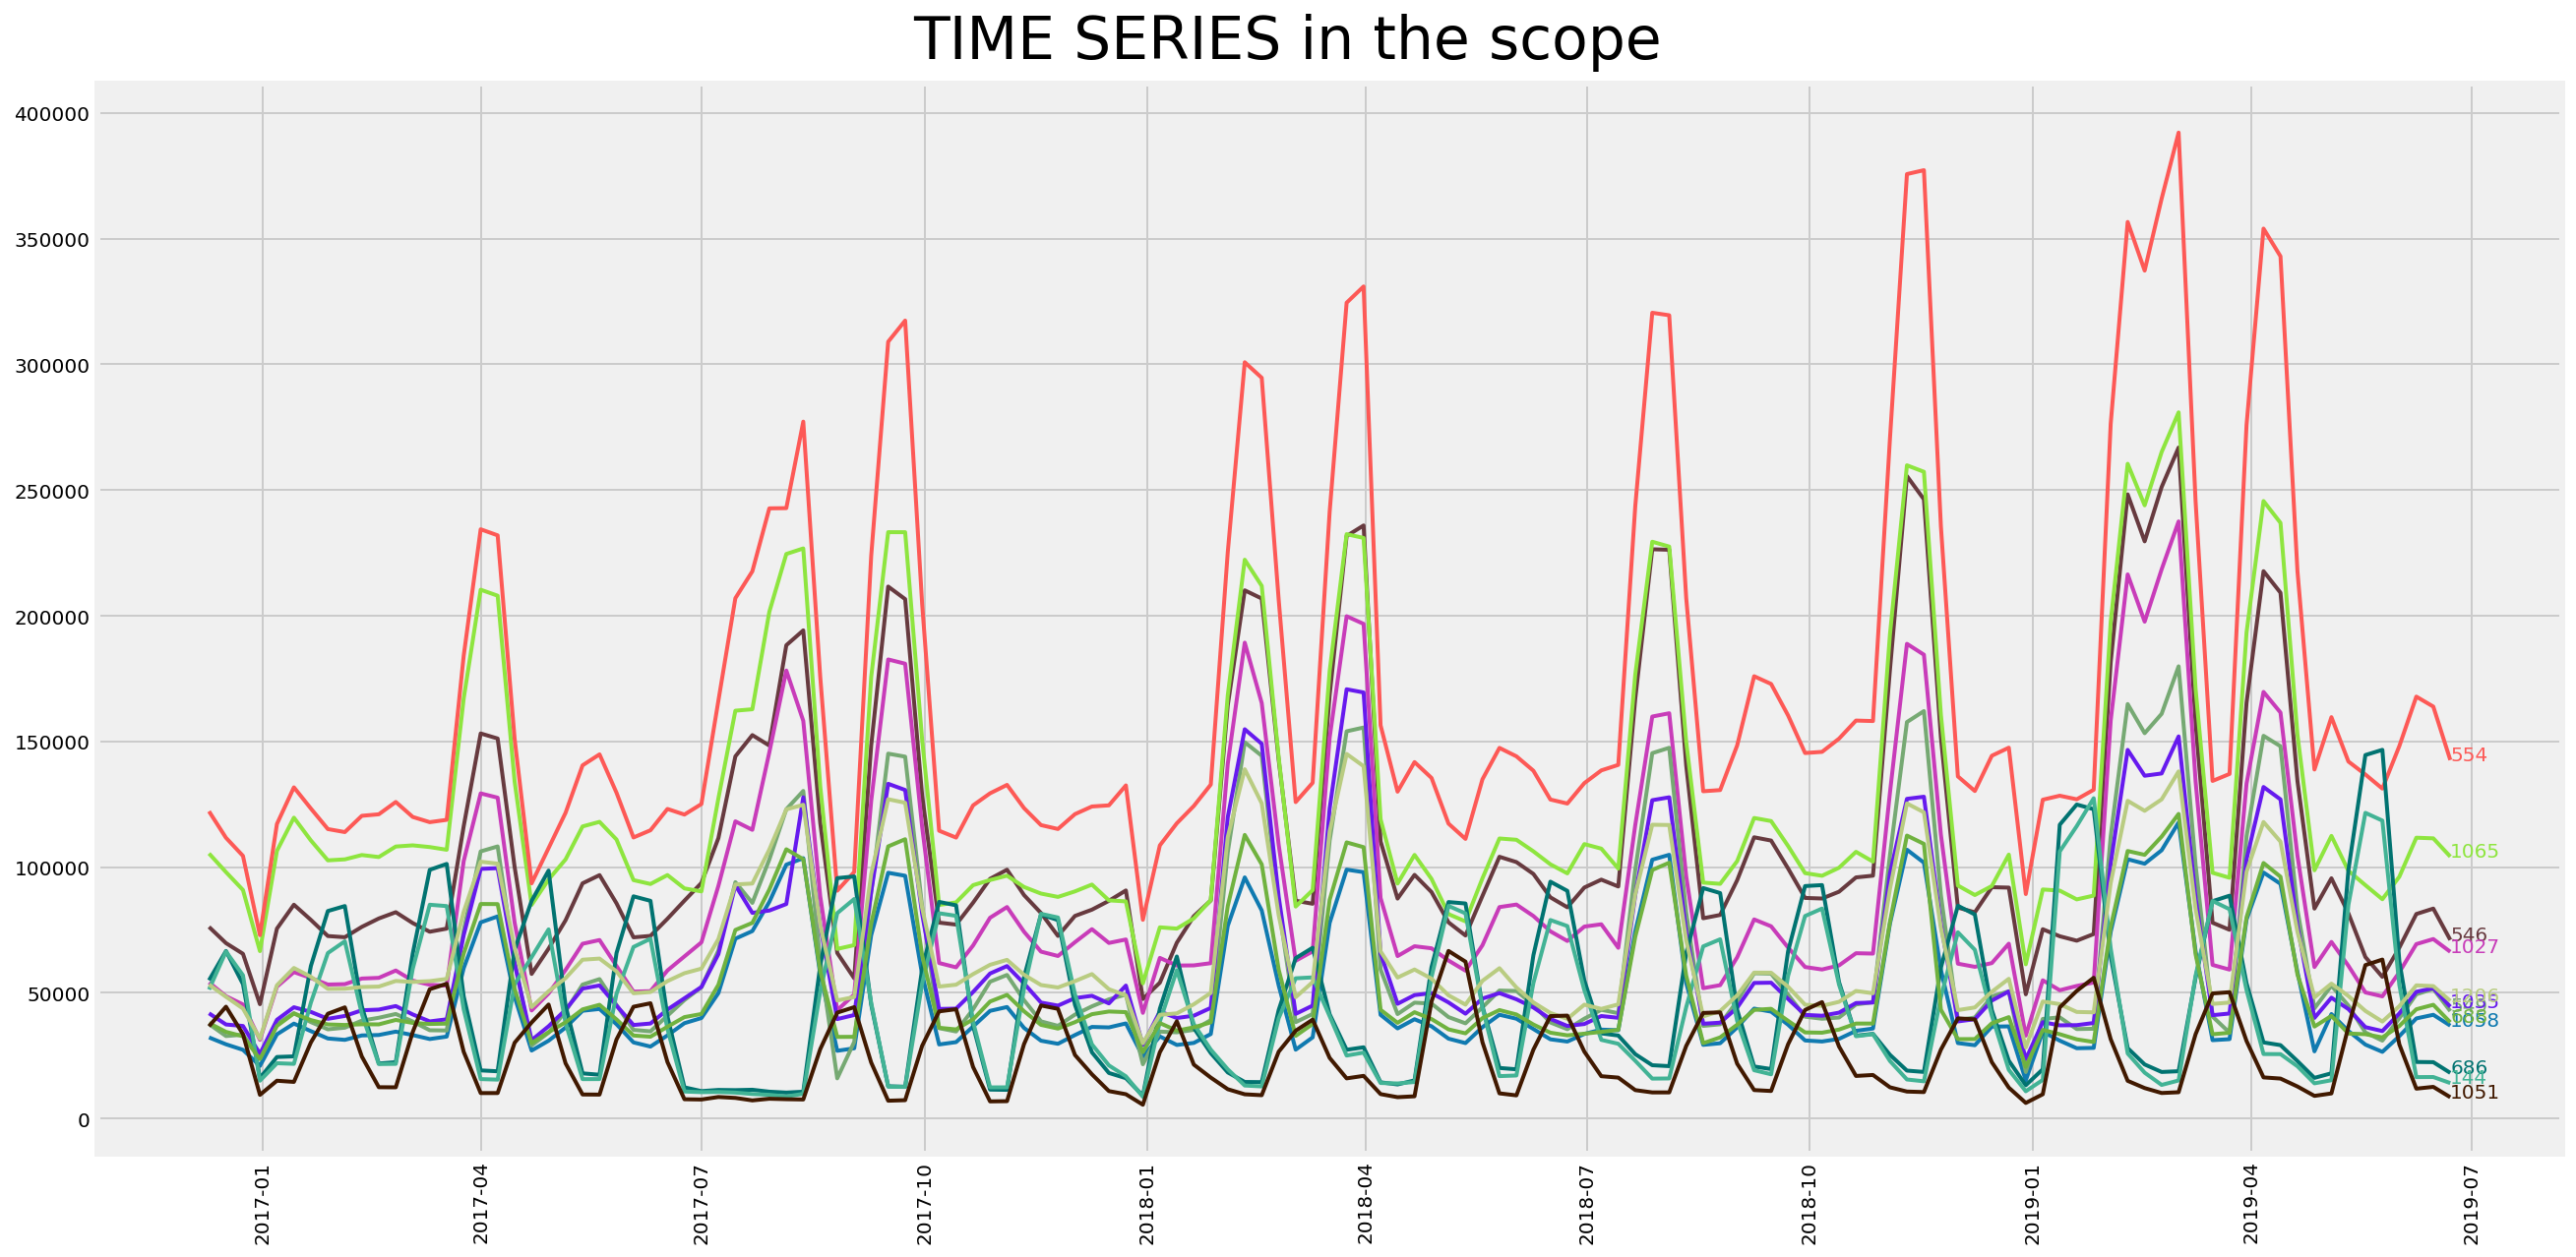

In [4]:
plt.figure(figsize=figsize)
plt.xticks(rotation=90)
plt.suptitle("TIME SERIES in the scope", fontsize=30, y=0.93)

for i,s in enumerate(set(df[df.scope == 1]['sku'])):
    plt.plot(train[train.sku == s].Date, train[train.sku == s].target, color=mycolors[i])
    last_x, last_y = train[train.sku == s].Date.values[-1], train[train.sku == s].target.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

## Correlation between timeseries in the scope

In [5]:
from scipy.stats import pearsonr

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="Blues",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    
    
series_df = pd.DataFrame()
series_df['Date'] = df['Date'].drop_duplicates()
series_df = series_df.sort_values(['Date'])
series_df = series_df.reset_index(drop=True)

for s in sorted(set(df[df.scope == 1]['sku'])):
    series_df[str(s)] = np.array(df[df.sku == s]['sales w-1'])

series_df

Date      144       546       549       554      686       688  \
0   2016-12-10      NaN       NaN       NaN       NaN      NaN       NaN   
1   2016-12-17  51320.0   76232.0   37595.0  122206.0  54995.0   37967.0   
2   2016-12-24  66431.0   69788.0   32822.0  111678.0  66652.0   34485.0   
3   2016-12-31  57001.0   65540.0   33366.0  104479.0  53490.0   32718.0   
4   2017-01-07  15052.0   45488.0   23845.0   72960.0  16100.0   23688.0   
..         ...      ...       ...       ...       ...      ...       ...   
153 2019-11-16  17765.0  184617.0  125244.0  304125.0  23528.0  100710.0   
154 2019-11-23  40594.0  110472.0   68474.0  195966.0  56078.0   56313.0   
155 2019-11-30  57970.0   54079.0   29606.0  118041.0  72004.0   30053.0   
156 2019-12-07  58818.0   55145.0   28557.0  116758.0  69134.0   30378.0   
157 2019-12-14  35888.0   59591.0   32141.0  122006.0  41194.0   32655.0   

         1027      1035     1051     1058      1065      1206  
0         NaN       NaN      NaN      NaN       NaN       NaN  
1     54158.0   41870.0  36721.0  32275.0  105446.0   53301.0  
2     48676.0   37417.0  44502.0  29540.0   98031.0   48441.0  
3     45389.0   36831.0  33581.0  27343.0   90915.0   43767.0  
4     31329.0   25737.0   9425.0  20943.0   66600.0   31760.0  
..        ...       ...      ...      ...       ...       ...  
153  145660.0  122639.0  14155.0  87767.0  208241.0  111353.0  
154   84895.0   70778.0  32870.0  48328.0  123955.0   63359.0  
155   43323.0   35221.0  43650.0  25172.0   71502.0   35238.0  
156   45174.0   35633.0  42545.0  25438.0   72675.0   34242.0  
157   47611.0   38087.0  24597.0  27794.0   79456.0   37889.0  

[158 rows x 13 columns]

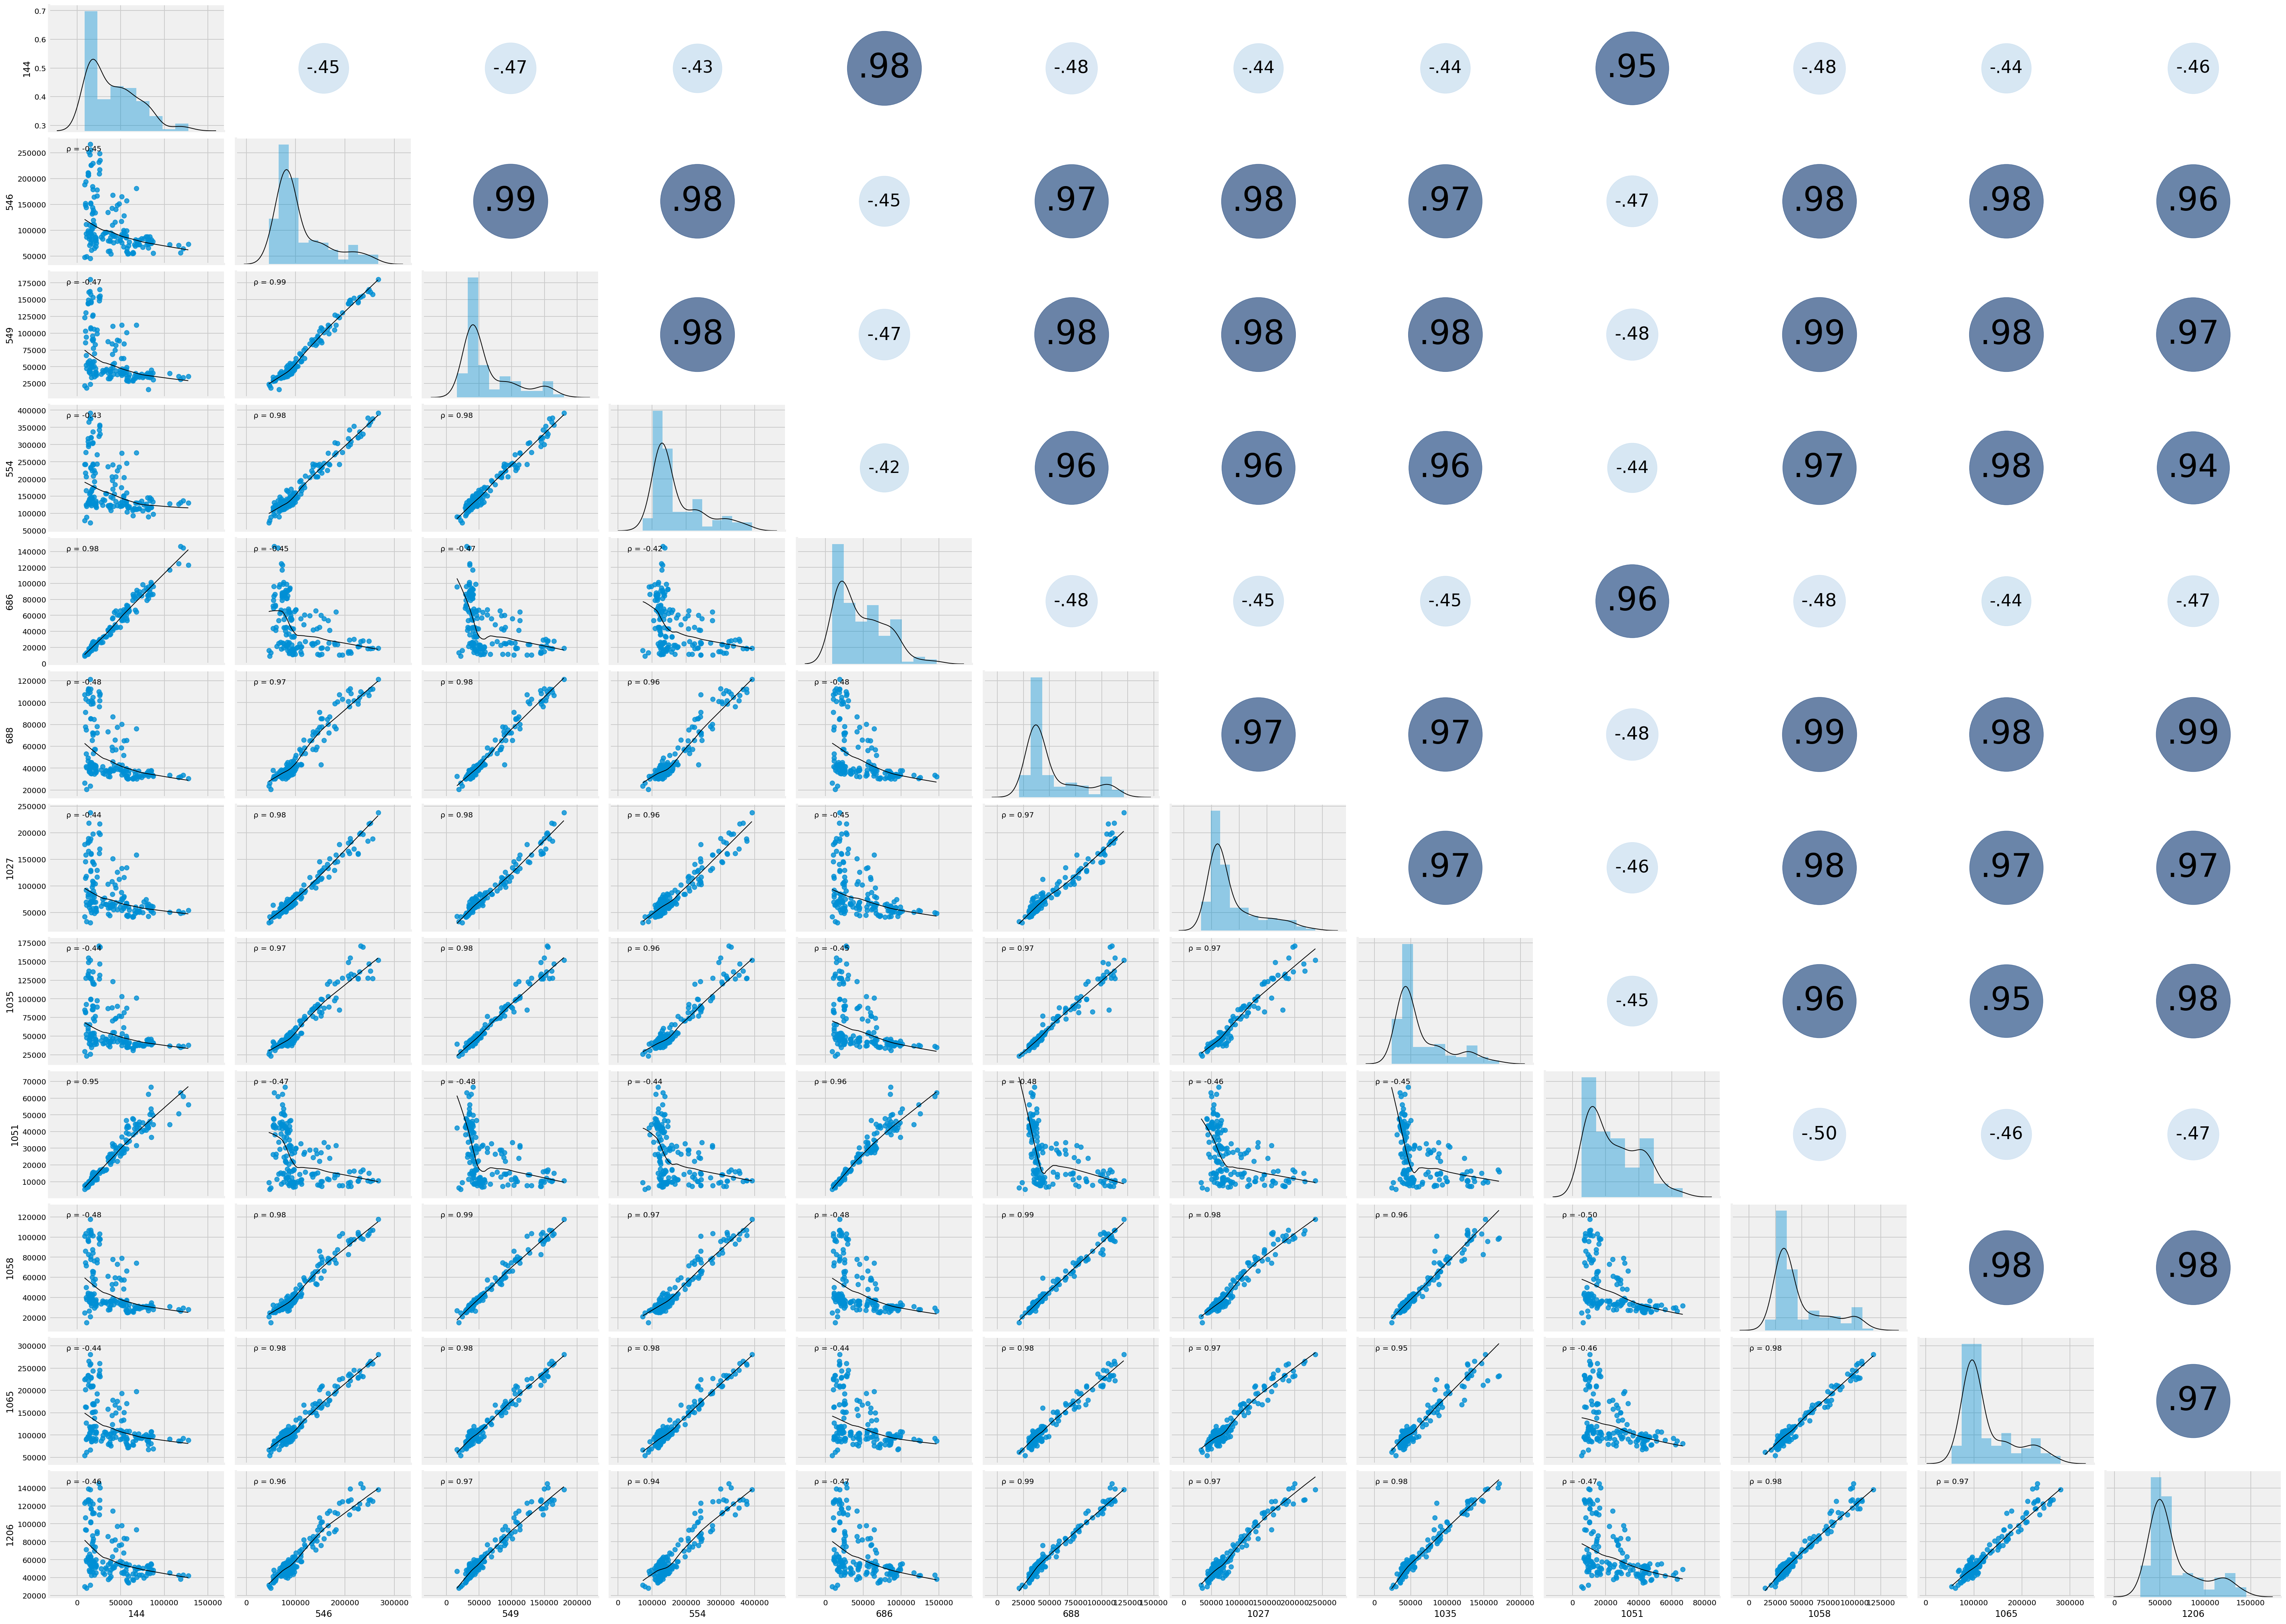

In [6]:
# g = sns.pairplot(stocks,palette=["Blues_d"])
g = sns.PairGrid(series_df, aspect=1.4, diag_sharey=False)
g.map_lower(corrfunc)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'Black','linewidth':1})
g.map_diag(sns.distplot, kde_kws={'color': 'Black','linewidth':1})
g.map_upper(corrdot)
plt.show()

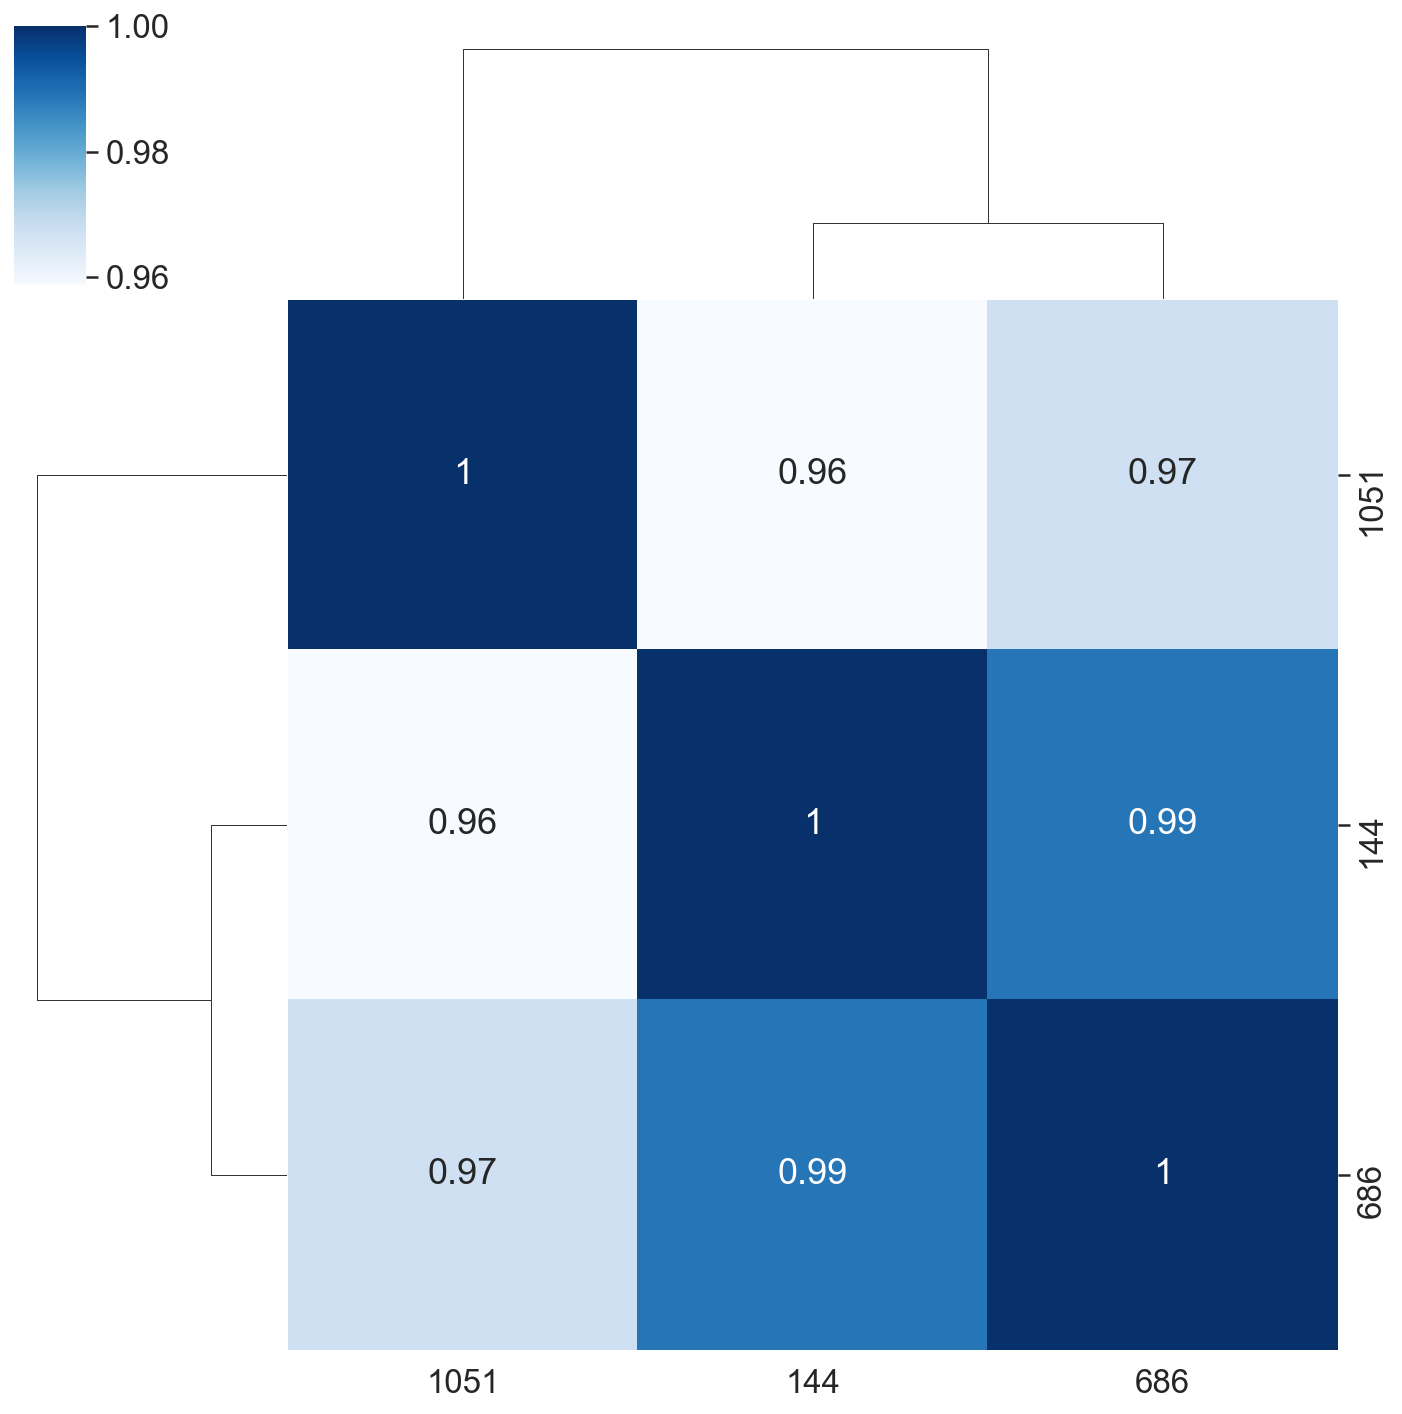

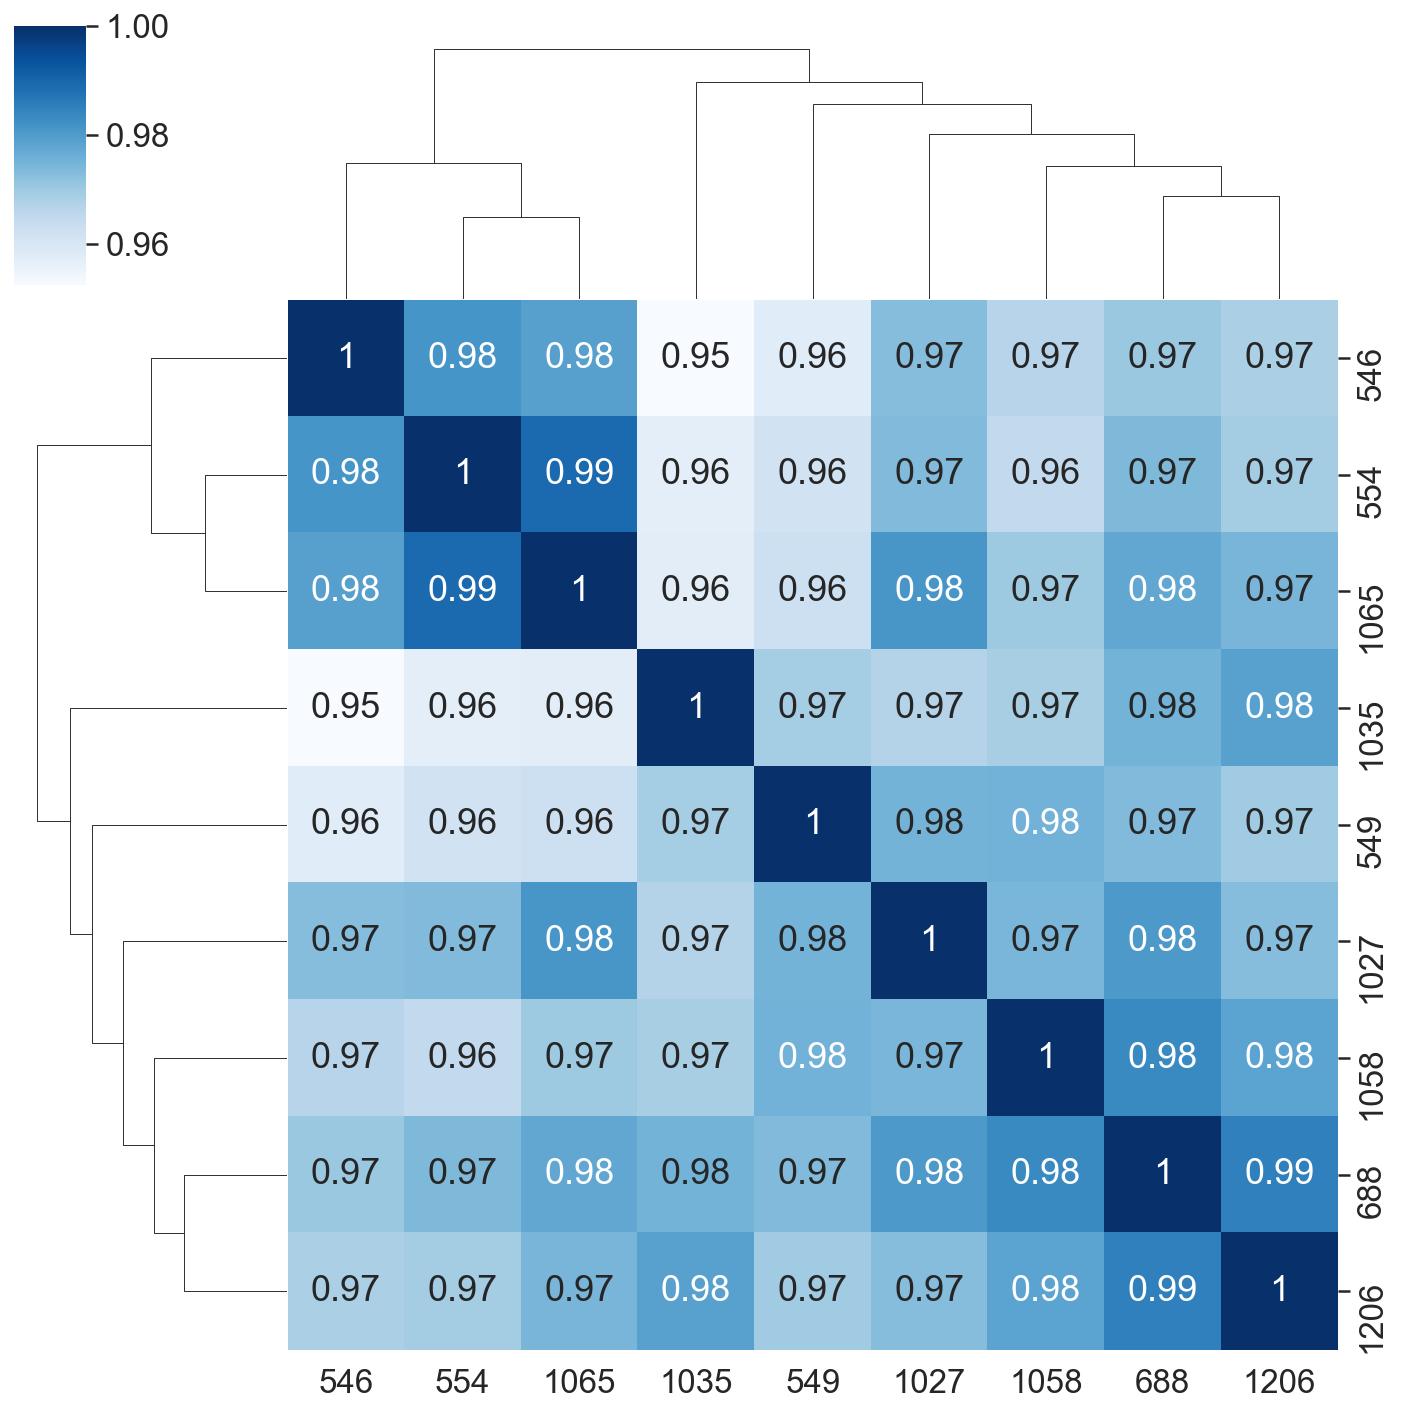

In [7]:
cluster_1 = series_df[['Date', '144', '686', '1051']]
cluster_2 = series_df.drop(columns=['144', '686', '1051'])

weekly_returns_1 = cluster_1.drop(columns=['Date']).pct_change().dropna()
weekly_returns_2 = cluster_2.drop(columns=['Date']).pct_change().dropna()

correlations = weekly_returns_1.corr()
sns.set(font_scale=1.5)
sns.clustermap(correlations, cmap="Blues", annot=True);

correlations = weekly_returns_2.corr()
sns.set(font_scale=1.5)
sns.clustermap(correlations, cmap="Blues", annot=True);

In [8]:
print('------------------------------------------------------------------')
print("-----------------------  CLUSTER 1  ------------------------------")
print('------------------------------------------------------------------')

for i in cluster_1.drop(columns=['Date']).columns:
    print('Autocorrelation of the series of ' + i + ': ' + str(series_df[i].autocorr()))
    print('Autocorrelation of the weekly_returns ' + i + ': ' + str(weekly_returns_1[i].autocorr()))
    print('------------------------------------------------------------------')
    
print('\n')

print('------------------------------------------------------------------')
print("-----------------------  CLUSTER 2  ------------------------------")
print('------------------------------------------------------------------')

for i in cluster_2.drop(columns=['Date']).columns:
    print('Autocorrelation of the series ' + i + ': : ' + str(series_df[i].autocorr()))
    print('Autocorrelation of the weekly_returns ' + i + ': : ' + str(weekly_returns_2[i].autocorr()))
    print('------------------------------------------------------------------')


------------------------------------------------------------------
-----------------------  CLUSTER 1  ------------------------------
------------------------------------------------------------------
Autocorrelation of the series of 144: 0.6339365782661418
Autocorrelation of the weekly_returns 144: 0.11463290233976849
------------------------------------------------------------------
Autocorrelation of the series of 686: 0.6230254087510797
Autocorrelation of the weekly_returns 686: 0.09952686427343406
------------------------------------------------------------------
Autocorrelation of the series of 1051: 0.6128674409612107
Autocorrelation of the weekly_returns 1051: 0.13731614566745182
------------------------------------------------------------------


------------------------------------------------------------------
-----------------------  CLUSTER 2  ------------------------------
------------------------------------------------------------------
Autocorrelation of the series 546

# Hypothesis Test - Are series random walks?

### We can reject with 95% of confidence that series in the scope are not random walk, because their p-value is lower than 0.05.

In [9]:
from statsmodels.tsa.stattools import adfuller

print('------------------------------------------------------------------')
print("-----------------------  CLUSTER 1  ------------------------------")
print('------------------------------------------------------------------')
for sku in cluster_1.drop(columns=['Date']).columns:
    adf = adfuller(series_df[sku].dropna())
    print("p-value of " + sku + " sales: %.4f"%adf[1])
    print("-----------------------------------------------")
    
print('\n')

print('------------------------------------------------------------------')
print("-----------------------  CLUSTER 2  ------------------------------")
print('------------------------------------------------------------------')
for sku in cluster_2.drop(columns=['Date']).columns:
    adf = adfuller(series_df[sku].dropna())
    print("p-value of " + sku + " sales: %.4f"%adf[1])
    print("-----------------------------------------------")

------------------------------------------------------------------
-----------------------  CLUSTER 1  ------------------------------
------------------------------------------------------------------
p-value of 144 sales: 0.0000
-----------------------------------------------
p-value of 686 sales: 0.0000
-----------------------------------------------
p-value of 1051 sales: 0.0000
-----------------------------------------------


------------------------------------------------------------------
-----------------------  CLUSTER 2  ------------------------------
------------------------------------------------------------------
p-value of 546 sales: 0.0000
-----------------------------------------------
p-value of 549 sales: 0.0012
-----------------------------------------------
p-value of 554 sales: 0.0016
-----------------------------------------------
p-value of 688 sales: 0.0000
-----------------------------------------------
p-value of 1027 sales: 0.0000
--------------------------

### All the series in the scope (cluste1 and cluster2) are all stationary with 95% of confidence.

In [10]:
for sku in sorted(set(df.sku)):
    adf = adfuller(df[df.sku == sku]["sales w-1"].dropna())
    if adf[1] > 0.05:
        print("p-value of " + str(sku) + " sales: %.4f"%adf[1])
        print("-----------------------------------------------")

p-value of 1365 sales: 0.6810
-----------------------------------------------
p-value of 1472 sales: 0.2224
-----------------------------------------------
p-value of 1554 sales: 0.1126
-----------------------------------------------
p-value of 1600 sales: 0.9102
-----------------------------------------------
p-value of 1618 sales: 0.5122
-----------------------------------------------
p-value of 2360 sales: 0.0802
-----------------------------------------------
p-value of 2365 sales: 0.5235
-----------------------------------------------
p-value of 2678 sales: 0.3538
-----------------------------------------------
p-value of 2681 sales: 0.4374
-----------------------------------------------
p-value of 2682 sales: 0.8440
-----------------------------------------------
p-value of 2683 sales: 0.4191
-----------------------------------------------
p-value of 2696 sales: 0.0736
-----------------------------------------------
p-value of 2698 sales: 0.2258
----------------------------------

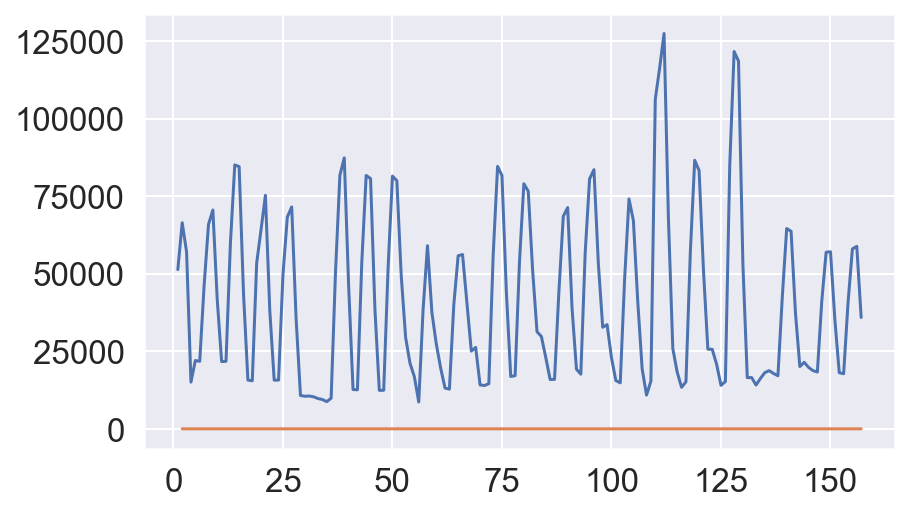

In [11]:
log_144 = np.log(series_df['144'])
plt.plot(series_df['144'], label="Random Walk");
plt.plot(log_144.diff(), label="First Differences");

### Here we have made stationary the series with sku = 144.

In [12]:
ad_fuller_diff_144 = adfuller(series_df['144'].diff().dropna())
ad_fuller_log_144 = adfuller(log_144.dropna())
print ('Diff p-value is: ' + str(ad_fuller_diff_144[1]))
print ('Logarithm p-value is: ' + str(ad_fuller_log_144[1]))

Diff p-value is: 1.5804348442412424e-07
Logarithm p-value is: 6.336283897477098e-21


### Both the series with first difference(1) and logarithm are stationary.  

In [25]:
from preprocessing.preprocessing import preprocessing

df_prepr = preprocessing(pd.read_csv("../dataset/original/train.csv"), pd.read_csv("../dataset/original/x_test.csv"))

def create_dict_of_series(df):
    series_dict = {}
    
    for sku in sorted(set(df.sku)):
        single_df = pd.DataFrame()
        single_df['Date'] = df[df.sku == sku]['Date'].drop_duplicates()
        single_df['pack'] = df[df.sku == sku]['pack']
        single_df['size (GM)'] = df[df.sku == sku]['size (GM)']
        single_df['brand'] = df[df.sku == sku]['brand']
        single_df['price'] = df[df.sku == sku]['price']
        single_df['POS_exposed w-1'] = df[df.sku == sku]['POS_exposed w-1']
        single_df['volume_on_promo w-1'] = df[df.sku == sku]['volume_on_promo w-1']
        single_df['sales w-1'] = df[df.sku == sku]['sales w-1']
        single_df['scope'] = df[df.sku == sku]['scope']
        
        if 'real_target' in df.columns:
            single_df['real_target'] = df[df.sku == sku]['real_target']
        
        if 'target' in df.columns: 
            single_df['target'] = df[df.sku == sku]['target']
        
        single_df = single_df.reset_index(drop = True)
        single_df = single_df.sort_values(['Date'])
        series_dict[sku] = single_df
    
    return series_dict


prepr_series = create_dict_of_series(df_prepr)

series_dict = create_dict_of_series(df)
series_dict.keys()

dict_keys([144, 546, 549, 554, 686, 688, 1027, 1035, 1051, 1058, 1065, 1206, 1356, 1365, 1371, 1472, 1516, 1554, 1600, 1603, 1608, 1618, 1633, 1732, 2249, 2360, 2365, 2396, 2401, 2410, 2678, 2681, 2682, 2683, 2689, 2696, 2698, 2704, 2705, 2707, 2711, 2712, 2718])

In [26]:
def dict_in_scope(df_dict):
    series_in_scope_dict = {}

    for key in df_dict.keys():
        if df[df.sku == key].scope.values.all() == 1:
            series_in_scope_dict[key] = df_dict[key]
    
    return series_in_scope_dict

df_dict_prepr = dict_in_scope(prepr_series)

series_in_scope_dict = dict_in_scope(series_dict)

train_dict = dict_in_scope(create_dict_of_series(train))
test_dict = dict_in_scope(create_dict_of_series(test))

# ARIMA model

## Let's start with an autoregressive model.

In [38]:
import pmdarima as pm
import sys
from statsmodels.tsa.arima_model import ARIMA

sys.path.append('../')
from metrics.MAPE import MAPE

global_predictions = []
real_values = []
log_values = []

iteration = 0

for key in sorted(df_dict_prepr.keys()):
    # One different model for each sku
    history = [x for x in df_dict_prepr[key]['target'][:-25]]
    stats_estimated = pm.auto_arima(history)
    log_values.extend(np.array(df_dict_prepr[key]['sales w-1'][-24:]).astype(float))
    real_values.extend(np.array(df_dict_prepr[key]['real_target'][-25:-1]).astype(float))
    predictions_single_sku = list()
    print("Predictions for " + str(key) + ": ")
    
    for t in range(25-1):
        model = SARIMAX(history, order=stats_estimated.order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions_single_sku.append(yhat)
        global_predictions.append(yhat)
        if t is not 24:
            obs = np.array(df_dict_prepr[key]['sales w-1'][-25:])[t+1].astype(float)
            history.append(obs)
            print('log_pred = %f,    log_real = %f,    real_pred = %f,    real = %f' % (yhat, obs, np.expm1(yhat),real_values[t + iteration*24 - 1]))
    
    print("\n")
    iteration += 1
    
MAPE(real_values, np.expm1(global_predictions))

Predictions for 144: 
log_pred = 9.369914,    log_real = 9.694555,    real_pred = 11729.108978,    real = 35888.000000
log_pred = 9.808609,    log_real = 9.804496,    real_pred = 18188.676555,    real = 16228.000000
log_pred = 10.000381,    log_real = 9.838896,    real_pred = 22033.853247,    real = 18114.000000
log_pred = 10.072315,    log_real = 9.788862,    real_pred = 23677.316302,    real = 18748.000000
log_pred = 9.982299,    log_real = 9.747185,    real_pred = 21639.001627,    real = 17833.000000
log_pred = 9.984386,    log_real = 10.659469,    real_pred = 21684.207119,    real = 17105.000000
log_pred = 10.873248,    log_real = 11.075226,    real_pred = 52745.232683,    real = 42593.000000
log_pred = 10.793647,    log_real = 11.061422,    real_pred = 48709.336172,    real = 64551.000000
log_pred = 10.826455,    log_real = 10.528570,    real_pred = 50333.966049,    real = 63666.000000
log_pred = 10.292515,    log_real = 9.906932,    real_pred = 29509.914183,    real = 37367.00000

56.46332229631877

In [32]:
# error = mean_squared_error(real_values, global_predictions)
# print('Test MSE: %.3f' % error)

In [33]:
# plt.plot(real_values)
# plt.plot(global_predictions, color='red')
# plt.show()

In [41]:
df_ens = pd.read_csv("../preds.csv")
df_ens

Date   sku     target  real_target  \
0    2019-06-29   144   9.694555      16228.0   
1    2019-06-29   546  11.025295      61407.0   
2    2019-06-29   549  10.427565      33777.0   
3    2019-06-29   554  11.717286     122673.0   
4    2019-06-29   686   9.960718      21177.0   
..          ...   ...        ...          ...   
295  2019-12-14  1035        NaN          NaN   
296  2019-12-14  1051        NaN          NaN   
297  2019-12-14  1058        NaN          NaN   
298  2019-12-14  1065        NaN          NaN   
299  2019-12-14  1206        NaN          NaN   

     log_prediction_lgb_no_cluster_1  prediction_lgb_no_cluster_1  \
0                           9.616715                 15012.651166   
1                          11.138380                 68759.161165   
2                          10.570172                 38954.388658   
3                          11.809471                134519.367335   
4                           9.834768                 18670.775315   
..                               ...                          ...   
295                        10.609182                 40504.060145   
296                         9.644808                 15440.406960   
297                        10.345556                 31117.444334   
298                        11.403439                 89628.454429   
299                        10.629722                 41344.640203   

     pred_linear_regression       ensemble     pred_arima  
0              38644.855603   16956.375295   11707.875336  
1              65647.271390   67740.931557   63702.369495  
2              37278.964631   38400.153564   37564.084201  
3             139833.660546  133633.276480  132601.010312  
4              47118.258091   21008.825072   15119.181312  
..                      ...            ...            ...  
295            41871.908468   40197.139528   38005.423711  
296            15968.771345   15329.381662   15023.004612  
297            30766.689842   30747.025739   28349.819530  
298            91162.391113   88784.780334   81084.069206  
299            44549.171130   41198.196559   39204.137692  

[300 rows x 9 columns]

In [42]:
df_ens = pred.sort_values(['sku', 'Date'])
df_ens['pred_arima_dave'] = global_predictions

In [53]:
print('\033[1m'+ "LIGHTGBM MAPE: " +'\033[0m' \
      + f"{MAPE(df_ens.dropna().real_target, df_ens.dropna().prediction_lgb_no_cluster_1)}")
print('\033[1m'+ "LINEAR REGRESSION MAPE: " +'\033[0m' \
      + f"{MAPE(df_ens.dropna().real_target, df_ens.dropna().pred_linear_regression)}")
print('\033[1m'+ "ARIMA MAPE: " +'\033[0m' \
      + f"{MAPE(df_ens.dropna().real_target, df_ens.dropna().pred_arima_dave)}")
a = .09
b = .89
c = .01
df_ens['ensemble'] = a*df_ens.pred_linear_regression+b*df_ens.prediction_lgb_no_cluster_1+c*df_ens.pred_arima
print('\033[1m'+ "ENSEMBLE MAPE: " +'\033[0m' + f"{MAPE(df_ens.dropna().real_target, df_ens.dropna().ensemble)}")

LIGHTGBM MAPE: 8.745968729353827
LINEAR REGRESSION MAPE: 20.801792479250565
ARIMA MAPE: 18.495707867085752
ENSEMBLE MAPE: 7.86043582776472


In [54]:
df_ens

Date   sku     target  real_target  \
0    2019-06-29   144   9.694555      16228.0   
12   2019-07-06   144   9.804496      18114.0   
24   2019-07-13   144   9.838896      18748.0   
36   2019-07-20   144   9.788862      17833.0   
48   2019-07-27   144   9.747185      17105.0   
..          ...   ...        ...          ...   
251  2019-11-16  1206  11.056588      63359.0   
263  2019-11-23  1206  10.469909      35238.0   
275  2019-11-30  1206  10.441237      34242.0   
287  2019-12-07  1206  10.542443      37889.0   
299  2019-12-14  1206        NaN          NaN   

     log_prediction_lgb_no_cluster_1  prediction_lgb_no_cluster_1  \
0                           9.616715                 15012.651166   
12                          9.758879                 17306.218549   
24                          9.950444                 20960.520797   
36                          9.669960                 15833.708111   
48                          9.954616                 21048.167347   
..                               ...                          ...   
251                        11.021242                 61158.603800   
263                        10.500888                 36346.778457   
275                        10.560790                 38590.615450   
287                        10.522016                 37122.895608   
299                        10.629722                 41344.640203   

     pred_linear_regression      ensemble     pred_arima  pred_arima_dave  
0              38644.855603  16956.375295   11707.875336     19109.904463  
12             41831.346859  19347.055736   17970.000959     20308.072486  
24             44754.712979  22865.775421   18298.774295     31769.203253  
36             37833.020944  17685.179184   18820.707964     22040.915048  
48             36489.632259  22188.149547   17121.370518     23387.896759  
..                      ...           ...            ...              ...  
251            80411.496496  62762.843542  109465.147463     70355.715027  
263            20070.853753  34535.736979   38072.731527     49668.201199  
275            23913.266394  36797.378930   29953.720446     37175.196413  
287            36937.090283  36720.703232   35698.801555     44404.072097  
299            44549.171130  41198.196559   39204.137692     47023.327031  

[300 rows x 10 columns]